In [262]:
from math import sin, pi
import numpy as np
from matplotlib import pyplot as plt
from random import random, seed

%matplotlib inline

In [263]:
# SIMULATION PARAMETERS
simulation_length = 100
dt = 1 / 100
seed(25)

# GlOBAL VARIABLES
current_time = 0
position = 0
velocity = 0
x = np.array([
    [0],
    [0]
])
P = np.diag([1.2, 1.2])
Q = np.array([
    [0, 0],
    [0, 0]
])

R = np.array([[12.]])

graph_data = {
    "time_stamps": [],
    "accelerations": [],
    "positions": [],
    "velocities": [],
    
    "imu_accelerations": [],
    "altimeter_height": [],
    
    "predicted_positions": [],
    "predicted_velocities": [],
}

while True:
    
    current_time += dt
    
    # physics (Calculate expected values)
    acc = 5 * sin((2 * pi / 10) * current_time) + 5  # expected acceleration
    position += velocity * dt + 0.5 * acc * dt * dt  # expected position
    velocity += acc * dt  # expected velocity
    
    # simulate sensors
    acc_imu = acc + 0.2  * (2 * random() - 1)  # measured acceleration
    pos_alt = position + 2 * (2 * random() - 1)  # measured position
    
    # kalman filter!!
    
    F = np.array([
        [1, dt],
        [0, 1]
    ])
    
    B = np.array([
        [0.5 * dt * dt],
        [dt]
    ])
    
    # x = Fx + Bu
    x_bar = np.dot(F, x) + B * acc_imu
    
    # P = FPF' + Q
    P = np.dot(np.dot(F, P), F.T) + Q
    
    H = np.array([[1, 0]])

    # y = z - Hx
    y = np.array([[pos_alt]]) - np.dot(H, x_bar)

    # S = HPH' + R
    S = np.dot(H, np.dot(P, H.T)) + R

    # K = PH'inv(S)
    K = np.dot(P, np.dot(H.T, np.linalg.inv(S)))
    
    x = x_bar + np.dot(K, y)
        
    # save data
    
    graph_data["time_stamps"].append(current_time)
    graph_data["accelerations"].append(acc)
    graph_data["velocities"].append(velocity)
    graph_data["positions"].append(position)
    
    graph_data["imu_accelerations"].append(acc_imu)
    graph_data["altimeter_height"].append(pos_alt)

    graph_data["predicted_positions"].append(x[0])
    graph_data["predicted_velocities"].append(x[1])
        
    if current_time > simulation_length:
        break

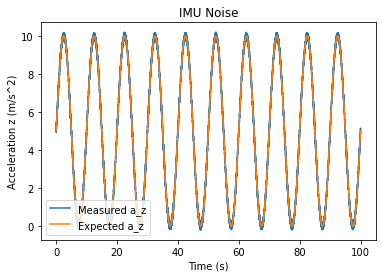

In [264]:
plt.title("IMU Noise")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration z (m/s^2)")

plt.plot(graph_data["time_stamps"], graph_data["imu_accelerations"], label='Measured a_z')
plt.plot(graph_data["time_stamps"], graph_data["accelerations"], label='Expected a_z')
plt.legend(loc='lower left')

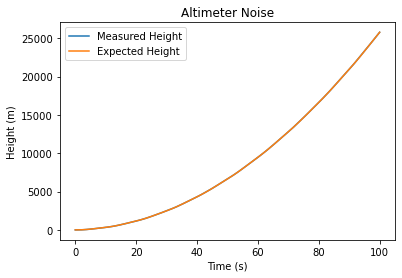

In [265]:
plt.title("Altimeter Noise")
plt.xlabel("Time (s)")
plt.ylabel("Height (m)")

plt.plot(graph_data["time_stamps"], graph_data["altimeter_height"], label='Measured Height')
plt.plot(graph_data["time_stamps"], graph_data["positions"], label='Expected Height')
plt.legend(loc='upper left')

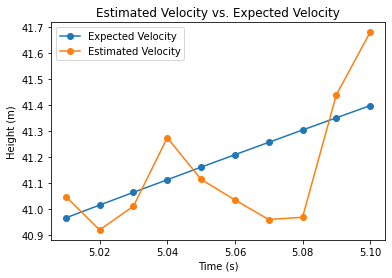

In [266]:
start = 500
points = 10
end = start + points

plt.title("Estimated Velocity vs. Expected Velocity")
plt.xlabel("Time (s)")
plt.ylabel("Height (m)")

plt.plot(graph_data["time_stamps"][start:end], graph_data["velocities"][start:end], marker='o', label='Expected Velocity')
plt.plot(graph_data["time_stamps"][start:end], graph_data["predicted_velocities"][start:end], marker='o', label='Estimated Velocity')

plt.legend(loc='upper left')

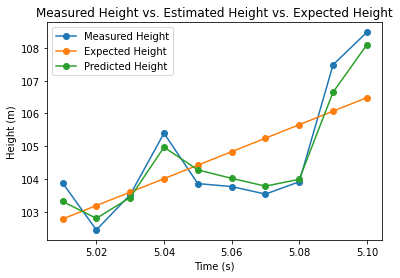

In [267]:
start = 500
points = 10
end = start + points

plt.title("Measured Height vs. Estimated Height vs. Expected Height")
plt.xlabel("Time (s)")
plt.ylabel("Height (m)")

plt.plot(graph_data["time_stamps"][start:end], graph_data["altimeter_height"][start:end], marker='o', label='Measured Height')
plt.plot(graph_data["time_stamps"][start:end], graph_data["positions"][start:end], marker='o', label='Expected Height')
plt.plot(graph_data["time_stamps"][start:end], graph_data["predicted_positions"][start:end], marker='o', label='Predicted Height')


plt.legend(loc='upper left')

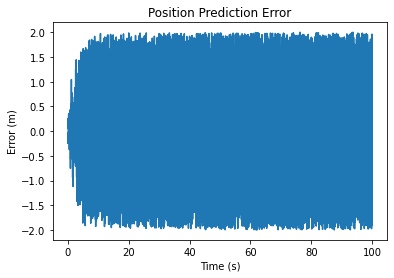

In [268]:
errors = [graph_data["positions"][x] - graph_data["predicted_positions"][x] for x in range(len(graph_data["positions"]))]
avg = sum(errors) / len(errors)

plt.title("Position Prediction Error")
plt.xlabel("Time (s)")
plt.ylabel("Error (m)")

plt.plot(graph_data["time_stamps"], errors)

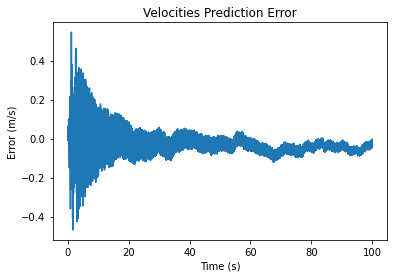

In [269]:
errors = [graph_data["velocities"][x] - graph_data["predicted_velocities"][x] for x in range(len(graph_data["velocities"]))]
avg = sum(errors) / len(errors)

plt.title("Velocities Prediction Error")
plt.xlabel("Time (s)")
plt.ylabel("Error (m/s)")

plt.plot(graph_data["time_stamps"], errors)